# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging
import sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=["attack=multiscale_simple"])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.user.data_idx = 1200
    cfg.case.user.num_data_points = 1

    cfg.attack.scale_space = "size" # size/sampling [i.e. whether the image is fed into the network at a smaller scale or just with lower freq]
    cfg.attack.resize="focus" # focus/upsampling
    cfg.attack.scale_pyramid="linear" # log/linear

    cfg.attack.optim.max_iterations = 3000
    cfg.attack.num_stages = 7
    cfg.attack.augmentations= dict(zoom=dict(out_size=224))
    cfg.attack.optim.optimizer = "adam-safe"
    cfg.attack.optim.signed = False

### Instantiate all parties

In [4]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture ResNet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      78:1 for target shape [1, 3, 224, 224] given that num_queries=1.


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1
    Number of user queries: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNet
    idx: 1200:unique
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type MultiScaleOptimizationAttacker) with settings:
    Hyperparameter Template: multiscale-invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=1 q=1. 
    Augmentations: Zoom(
  (up): Upsample(size=(224, 224), mode=bilinear)
)

    Optimization Setup:
        optimizer: adam-safe
        signed: False
        step_size: 0.1
        boxed: True
        m

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

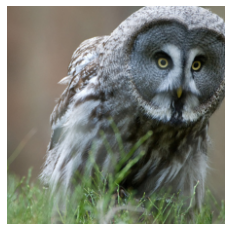

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

In [8]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

Recovered labels [24] through strategy bias-corrected.
| Now solving stage 1/7 with scale 32:
| S: 0 - It: 1 | Rec. loss: 0.9844 |  Task loss: 7.7132 | T: 0.13s
| S: 0 - It: 1001 | Rec. loss: 0.8343 |  Task loss: 1.0773 | T: 45.69s
| S: 0 - It: 2001 | Rec. loss: 0.5897 |  Task loss: 0.0000 | T: 38.45s
| S: 0 - It: 3000 | Rec. loss: 0.5768 |  Task loss: 0.0000 | T: 38.34s
| Now solving stage 2/7 with scale 64:
| S: 1 - It: 1 | Rec. loss: 1.0413 |  Task loss: 1.4085 | T: 0.04s
| S: 1 - It: 1001 | Rec. loss: 0.6940 |  Task loss: 0.0000 | T: 38.51s
| S: 1 - It: 2001 | Rec. loss: 0.5553 |  Task loss: 0.0000 | T: 38.50s
| S: 1 - It: 3000 | Rec. loss: 0.5337 |  Task loss: 0.0000 | T: 38.42s
| Now solving stage 3/7 with scale 96:
| S: 2 - It: 1 | Rec. loss: 1.0086 |  Task loss: 2.9561 | T: 0.04s
| S: 2 - It: 1001 | Rec. loss: 0.4688 |  Task loss: 0.0000 | T: 38.47s
| S: 2 - It: 2001 | Rec. loss: 0.5150 |  Task loss: 0.0000 | T: 38.50s
| S: 2 - It: 3000 | Rec. loss: 0.5025 |  Task loss: 0.0000 

/home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0463 | PSNR: 13.34 | FMSE: 3.4981e+02 | LPIPS: 0.84|
 R-PSNR: 13.55 | IIP-pixel: 0.00% | SSIM: 0.3131 | Label Acc: 100.00%


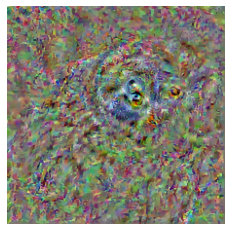

In [9]:
user.plot(reconstructed_user_data)